# Direct Regression - Bayesian Version

## Response Model

How well can we predict outcomes $Y$ conditional on treatment $T$ and other covariates $Z$?

### Treatent variables

   - **reduhl**	Completed re-education based on highest level of attainment
   - **redudl**	Completed re-education based on detailed qualifications
   - **redufl**	Completed re-education using highest lvl and detailed qualifications.

### Outcome variables
   - Mental health in 2019 (**mh**). This is the transformed mental health scores from the aggregation of mental health items of the SF-36 Health Survey, as reported by the individual in 2019. It ranges from 0 to 100, with higher scores indicating better mental health.  
   - Working hours in 2019 (**wkhr**) records the total number of hours the individual works in all jobs in a week on average. Working hours are set to 0 for those not working. 
   - Hourly Wages in 2019 (**rlwage**) records the average hourly wage for the individual’s main job in 2019. Hourly wages are set to 0 for those not working and set to missing for those reporting working more than 100 hours a week. 
   
#### Columns explicitly excluded
   - **xwaveid** (unique identifier)
   - **p_rcom*** (timing of completion of re-education, proxies treatment) TODO think about how we would include this
   - **p_cotrl** (first avail 2003)
   - **p_rdf*** (first avail 2012)

In [17]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.stats import norm
from cinspect.estimators import BayesianRidgeStat
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, DotProduct

from reed import drop_missing_treatment_or_outcome, Model, transform_outcome
from direct_regression import seperate_and_transform_data, print_unconditional_effects

%matplotlib inline

## Analysis Parameters

In [18]:
#optimisation_metric = 'neg_mean_squared_error'
#evaluation_metrics = ('r2','neg_mean_squared_error')
log_outcome=True
standardize_outcome=True
#load_from_cache=False
exclude_patterns = [
    '^reduhl$', '^rehllt$', '^redudl$', '^redufl$', '^redllt$', '^refllt$',
    '^rlwage$', '^mh$', '^mhbm$', '^wkhr$', '^y_', '^p_rcom','^p_rdf','^p_cotrl',
    '^xwaveid$','p_rcom18','^aedcq', '^abnfsty','^aedcqfpt','^aedqstdy'
]
data_load_func = lambda filepath: pd.read_csv(filepath, index_col='xwaveid')

#configuration_name = 'default'
outcome = 'y_wsce'
treatment = 'redufl'
test=False
data_file = "data/all_lasso_selected_100.csv"

## Load the data

Dropped 284 rows missing treatment or outcome.


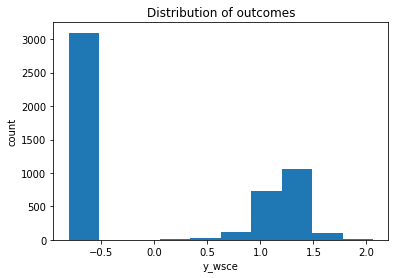

In [19]:
data = data_load_func(data_file)
drop_missing_treatment_or_outcome(data, treatment, outcome)
data[outcome] = transform_outcome(data[outcome],log_outcome, standardize_outcome)

    
plt.hist(data[outcome])
plt.xlabel(outcome)
plt.ylabel("count")
plt.title("Distribution of outcomes");

## Prepare data for modeling

- split into treated/control
- impute missing values and scale
- separate features from outcomes&treatments



In [20]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)
print("Control data dimensions: ", X0.shape)
print("Treated data dimensions:", X1.shape)

Control data dimensions:  (3789, 91)
Treated data dimensions: (1368, 91)


## Compute unconditional/unadjusted estimate of treatment effect

In [21]:
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:27%
Average outcome under Control:-0.14±0.02
Average outcome under Treatment:0.37±0.03
Unadjusted treatment estimate 0.51


## Statsmodels

### OLS

In [22]:
Xt = np.hstack((t[:, np.newaxis], X))
Xt = pd.DataFrame(data=Xt, columns=["treatment"] + features)
ols = sm.OLS(y, sm.add_constant(Xt))
res = ols.fit()
ate_ols = res.params.loc["treatment"]
ci_ols = res.conf_int().loc["treatment"]
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     39.92
Date:                Wed, 24 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:05:42   Log-Likelihood:                -5911.1
No. Observations:                5157   AIC:                         1.201e+04
Df Residuals:                    5064   BIC:                         1.262e+04
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0382      0.013     -2.996      0.0

## Scikit learn Bayesian Estimators

### Bayesian Ridge

In [23]:
br = BayesianRidgeStat()
br.fit(Xt, y)

score = br.score(Xt, y)
stats = br.model_statistics()
ate_blr, se_blr = stats.beta[0], stats.std_err[0]
ci_blr = np.squeeze(norm.interval(loc=beta, scale=se, alpha=[0.95]))

print("Bayesian Ridge simple model:")
print(f"  R-squared = {score:.4f}")
print(f"  ATE: {ate_blr:.4f} ({se_blr:.4f})")
print(f"  t: {stats.t_stat[0]:.4f}")
print(f"  p-value: {stats.p_value[0]:.4f}")
print(f"  CI (0.025, 0.975): [{ci_blr[0]:.4f}, {ci_blr[1]:.4f}]")

Bayesian Ridge simple model:
  R-squared = 0.4195
  ATE: 0.1102 (0.0224)
  t: 4.9268
  p-value: 0.0000
  CI (0.025, 0.975): [0.0664, 0.1541]


### Gaussian Process

In [24]:
kernel = WhiteKernel() + Matern(nu=1.5)
gpr = GaussianProcessRegressor(kernel=kernel)

# This takes a while for 5000 samples... (10 mins or so)
gpr.fit(Xt, y)
score = gpr.score(Xt, y)

In [25]:
# Counterfactual predictions
n = len(X)
Xt0 = pd.DataFrame(data=np.hstack((np.zeros((n, 1)), X)), columns=["treatment"] + features)
Xt1 = pd.DataFrame(data=np.hstack((np.ones((n, 1)), X)), columns=["treatment"] + features)
y_0, s_0 = gpr.predict(Xt0, return_std=True)
y_1, s_1 = gpr.predict(Xt1, return_std=True)

In [26]:
# ATE sampling
S = 3000
ate_samples = np.zeros(S)
norm_y0 = norm(loc=y_0, scale=s_0)
norm_y1 = norm(loc=y_1, scale=s_1)
for s in range(S):
    y_0_s = norm_y0.rvs()
    y_1_s = norm_y1.rvs()
    ate_samples[s] = y_1_s.mean() - y_0_s.mean()
    
ate_analytic = y_1.mean() - y_0.mean()
ate_gp, se_gp = np.mean(ate_samples), np.std(ate_samples, ddof=1)
ci_gp = np.squeeze(norm.interval(loc=ate_gp, scale=se_gp, alpha=[0.95]))

In [27]:
print("Gaussian Process (Matern 3/2):")
print(f"  R-squared = {score:.4f}")
print(f"  ATE: {ate_gp:.4f} ({se_gp:.4f}) -- no sampling: {ate_analytic:.4f}")
print(f"  CI (0.025, 0.975): [{ci_gp[0]:.4f}, {ci_gp[1]:.4f}]")

Gaussian Process (Matern 3/2):
  R-squared = 0.6074
  ATE: 0.1120 (0.0149) -- no sampling: 0.1118
  CI (0.025, 0.975): [0.0828, 0.1413]


## Plot ATE

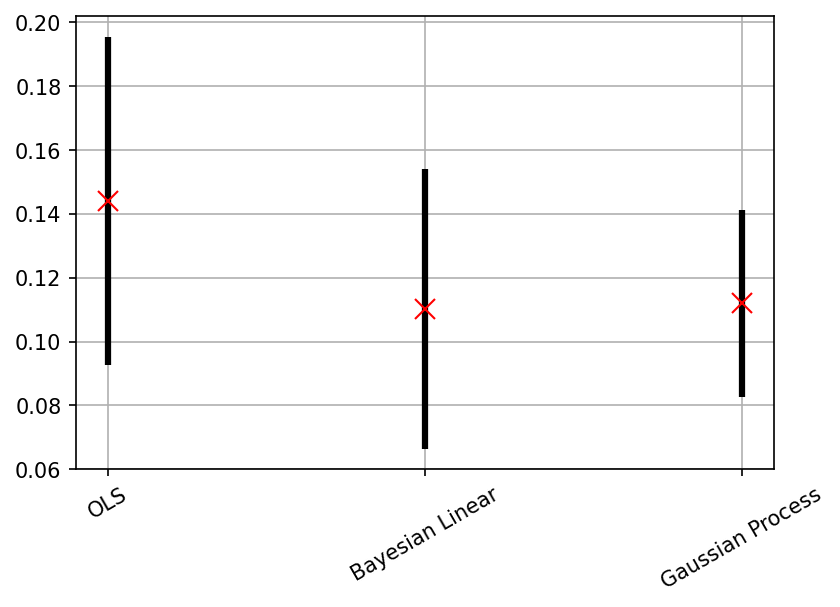

In [37]:
ate_labels = ["OLS", "Bayesian Linear", "Gaussian Process"]
ate = [ate_ols, ate_blr, ate_gp]
ci = [ci_ols, ci_blr, ci_gp]
ind = np.arange(len(ate))

plt.figure(dpi=150)
plt.vlines(ind, ymin=[c[0] for c in ci], ymax=[c[1] for c in ci], colors='k', linewidth=3)
plt.plot(ind, ate, 'rx', markersize=10)
plt.xticks(ind, labels=ate_labels, rotation=30)
plt.grid()
plt.show()